In [1]:
from astropy import units as u
import astropy.io.fits as fits
from astropy.table import vstack
from astropy.time import Time
from astropy.timeseries import TimeSeries, LombScargle
from astropy.stats import sigma_clip
from matplotlib import pyplot

from panoptes_client import Subject

import numpy
import pandas
import seaborn
import urllib

Broken libmagic installation detected. The python-magic module is installed but can't be imported. Please check that both python-magic and the libmagic shared library are installed correctly. Uploading media other than images may not work.


In [2]:
SWASP_ID = 74207238
FOLDING_PERIOD = 0 # Days. Set to 0 to run Lomb-Scargle
AUTO_FOLDED_PLOTS = 10 # How many of the top Lomb-Scargle periods to plot
PERIOD_MAX_DAYS = 600 # Max for Lomb-Scargle
PERIOD_MIN_DAYS = 1.0/24.0 # Min for Lomb-Scargle
SIGMA_CLIP = 4
START_TIME = 0 # Set to zero to set automatically for BHH subjects
END_TIME = 0 # Set to zero to set automatically for BHH subjects
VESPA_EXPORT = '../../superwasp-data/vespa-export.csv' # Set to None to skip loading superwasp.org FITS URLs

In [3]:
if type(SWASP_ID) is int:
    subject = Subject(SWASP_ID)
    if 'wasp_id' in subject.metadata:
        SWASP_ID = subject.metadata['wasp_id']
    if '#start_tmid' in subject.metadata:
        START_TIME = subject.metadata['#start_tmid']
    if '#end_tmid' in subject.metadata:
        END_TIME = subject.metadata['#end_tmid']

In [4]:
if VESPA_EXPORT is not None:
    vespa = pandas.read_csv(VESPA_EXPORT)
    fits_urls = vespa[vespa['SuperWASP ID'] == SWASP_ID.replace(' ', '')]['FITS URL'].unique()
else:
    fits_urls = []

In [5]:
if len(fits_urls) == 0:
    fits_url = 'http://wasp.warwick.ac.uk/lcextract?{}'.format(
        urllib.parse.urlencode(
            {'objid': SWASP_ID.replace('1SWASPJ', '1SWASP J')},
            quote_via=urllib.parse.quote,
        )
    )
else:
    fits_url = fits_urls[0]
fits_url

'http://wasp.warwick.ac.uk/lcextract?objid=1SWASP%20J193052.24-300403.3'

In [6]:
fits_file = fits.open(fits_url)
hjd_col = fits.Column(name='HJD', format='D', array=fits_file[1].data['TMID'] / 86400 + 2453005.5)
lc_data = fits.BinTableHDU.from_columns(fits_file[1].data.columns + fits.ColDefs([hjd_col]))
timeseries = TimeSeries.read(lc_data, time_column='HJD', time_format='jd')

In [7]:
f2mag = lambda f: 15 - 2.5 * numpy.log10(f)

In [8]:
if SIGMA_CLIP > 0:
    ts_flux = sigma_clip(timeseries['TAMFLUX2'], sigma=SIGMA_CLIP)
else:
    ts_flux = timeseries['TAMFLUX2']
ts_data = {
    'time': timeseries.time.jd,
    'flux': ts_flux,
    'err': timeseries['TAMFLUX2_ERR'],
    'camera': timeseries['CAMERA_ID'],
}

In [9]:
def get_folded_ts(orig_ts, period):
    ts = orig_ts.fold(period=period * 86400 * u.second)
    epoch_length = ts['time'].max() - ts['time'].min()
    ts_out = [ts]
    ts_new = ts.copy()
    ts_new['time'] = ts_new['time'] + epoch_length
    ts_out.append(ts_new)
    ts = vstack(ts_out)
    if SIGMA_CLIP > 0:
        ts_flux = sigma_clip(ts['TAMFLUX2'], sigma=SIGMA_CLIP)
    else:
        ts_flux = ts['TAMFLUX2']

    return {
        'time': ts.time.jd,
        'flux': ts_flux,
        'err': ts['TAMFLUX2_ERR'],
        'camera': ts['CAMERA_ID'],
    }

In [10]:
trimmed_timeseries = timeseries
if START_TIME > 0:
    START_TIME = Time(START_TIME / 86400 + 2453005.5, format='jd')
    trimmed_timeseries = trimmed_timeseries[trimmed_timeseries['time'] > START_TIME]
if END_TIME > 0:
    END_TIME = Time(END_TIME / 86400 + 2453005.5, format='jd')
    trimmed_timeseries = trimmed_timeseries[trimmed_timeseries['time'] < END_TIME]


C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


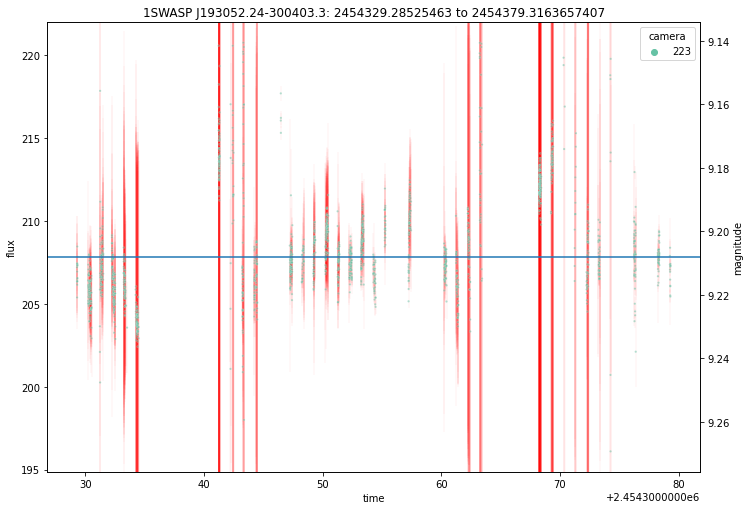

In [11]:
if trimmed_timeseries is not timeseries:
    if SIGMA_CLIP > 0:
        trimmed_ts_flux = sigma_clip(trimmed_timeseries['TAMFLUX2'], sigma=SIGMA_CLIP)
    else:
        trimmed_ts_flux = trimmed_timeseries['TAMFLUX2']
    trimmed_ts_data = {
        'time': trimmed_timeseries.time.jd,
        'flux': trimmed_ts_flux,
        'err': trimmed_timeseries['TAMFLUX2_ERR'],
        'camera': trimmed_timeseries['CAMERA_ID'],
    }
    f, ax = pyplot.subplots(figsize=(11.7,8.27))
    seaborn.scatterplot(
        data=trimmed_ts_data,
        x='time',
        y='flux',
        alpha=0.5,
        s=5,
        palette='Set2',
        hue='camera',
    )

    lims = pyplot.ylim()
    pyplot.axhline(numpy.median(trimmed_ts_flux))

    pyplot.errorbar(trimmed_ts_data['time'], trimmed_ts_data['flux'], yerr=trimmed_ts_data['err'], ecolor='red', ls='none', zorder=-1, alpha=0.5, elinewidth=0.1)

    pyplot.ylim(lims)
    ax2 = ax.twinx()
    ax2.set_ylim(f2mag(lims[0]), f2mag(lims[1]))
    ax2.set_ylabel('magnitude')
    pyplot.title(f"{SWASP_ID}: {START_TIME} to {END_TIME}")

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Text(0.5, 1.0, '1SWASP J193052.24-300403.3')

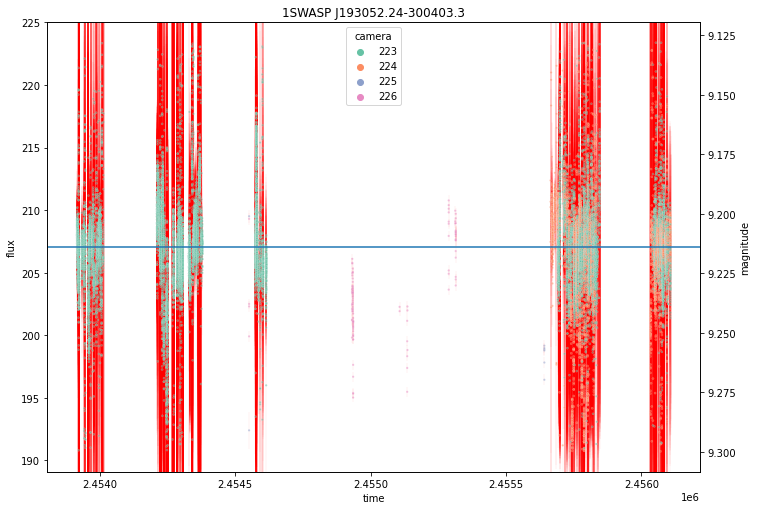

In [12]:
f, ax = pyplot.subplots(figsize=(11.7,8.27))
seaborn.scatterplot(
    data=ts_data,
    x='time',
    y='flux',
    alpha=0.5,
    s=5,
    palette='Set2',
    hue='camera',
)
lims = pyplot.ylim()
pyplot.axhline(numpy.median(ts_flux))

pyplot.errorbar(ts_data['time'], ts_data['flux'], yerr=ts_data['err'], ecolor='red', ls='none', zorder=-1, alpha=0.5, elinewidth=0.1)

pyplot.ylim(lims)
ax2 = ax.twinx()
ax2.set_ylim(f2mag(lims[0]), f2mag(lims[1]))
ax2.set_ylabel('magnitude')
pyplot.title(SWASP_ID)

In [13]:
if FOLDING_PERIOD == 0:
    frequency, power = LombScargle(ts_data['time'], ts_data['flux'], ts_data['err']).autopower()
    periods = pandas.DataFrame({'frequency': frequency, 'power': power, 'period': 1/frequency}).sort_values('power', ascending=False)
else:
    ls = None
    periods = pandas.DataFrame({'frequency': 1, 'power': [1], 'period': FOLDING_PERIOD})
periods

frequency         power    period
10979    1.002225  8.480340e-02  0.997780
10980    1.002316  7.945843e-02  0.997689
21965    2.005043  7.419351e-02  0.498742
21964    2.004952  7.043767e-02  0.498765
10978    1.002134  6.778991e-02  0.997871
...           ...           ...       ...
193838  17.693862  9.215247e-09  0.056517
94186    8.597482  8.893035e-09  0.116313
223123  20.367040  7.548503e-09  0.049099
173114  15.802145  2.624589e-09  0.063283
214098  19.543225  5.337582e-10  0.051169

[285501 rows x 3 columns]

In [14]:
periods['period'] = numpy.round(periods['period'], 1)
periods = periods.drop_duplicates(subset=('period',))
periods = periods[periods['period'] <= PERIOD_MAX_DAYS ]
periods = periods[periods['period'] >= PERIOD_MIN_DAYS ]
periods

frequency     power  period
10979   1.002225  0.084803     1.0
21965   2.005043  0.074194     0.5
32      0.002967  0.047888   337.1
33      0.003058  0.047625   327.0
34      0.003149  0.045868   317.5
...          ...       ...     ...
261     0.023870  0.000061    41.9
281     0.025696  0.000021    38.9
118     0.010817  0.000012    92.4
223     0.020401  0.000002    49.0
266     0.024327  0.000001    41.1

[643 rows x 3 columns]

[None]

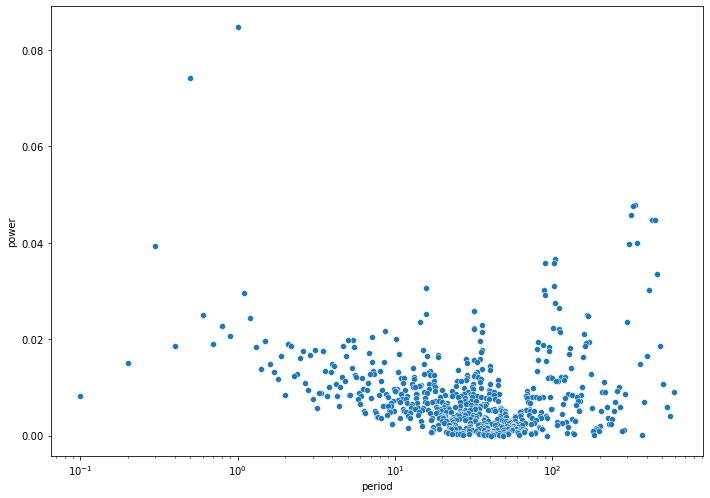

In [15]:
f, ax = pyplot.subplots(figsize=(11.7,8.27))
seaborn.scatterplot(data=periods, x='period', y='power').set(xscale="log")

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


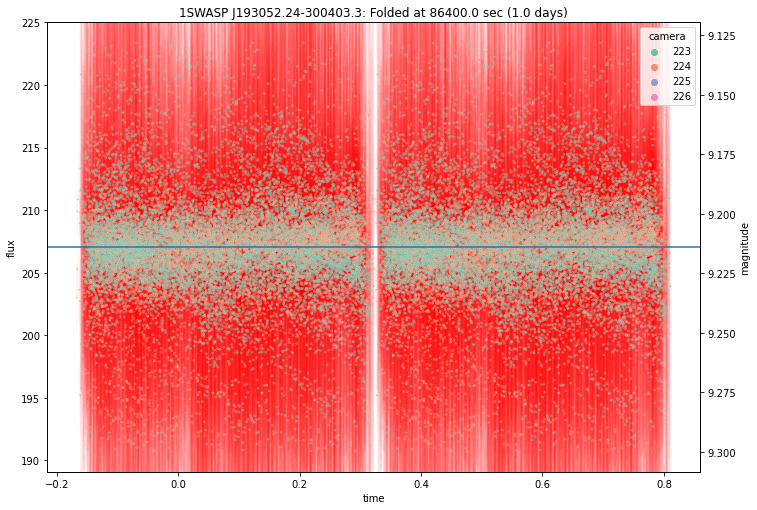

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


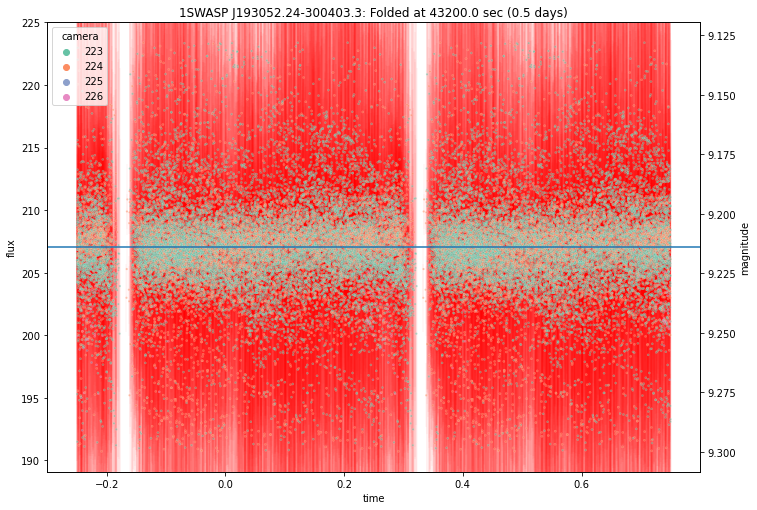

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


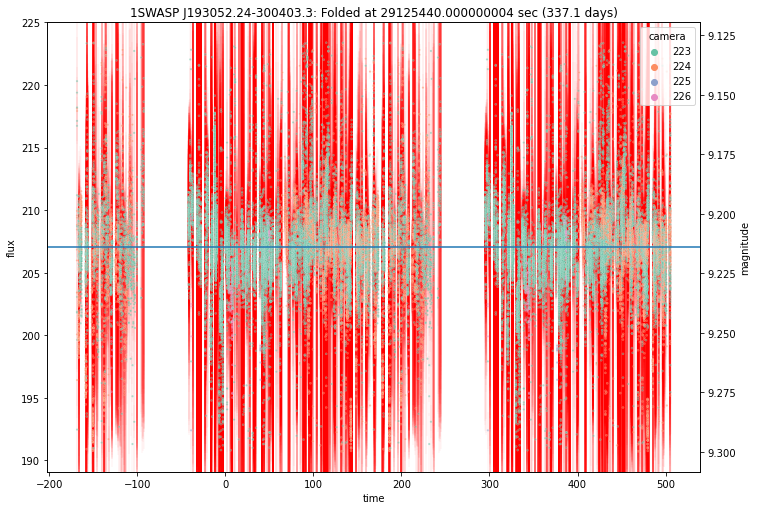

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


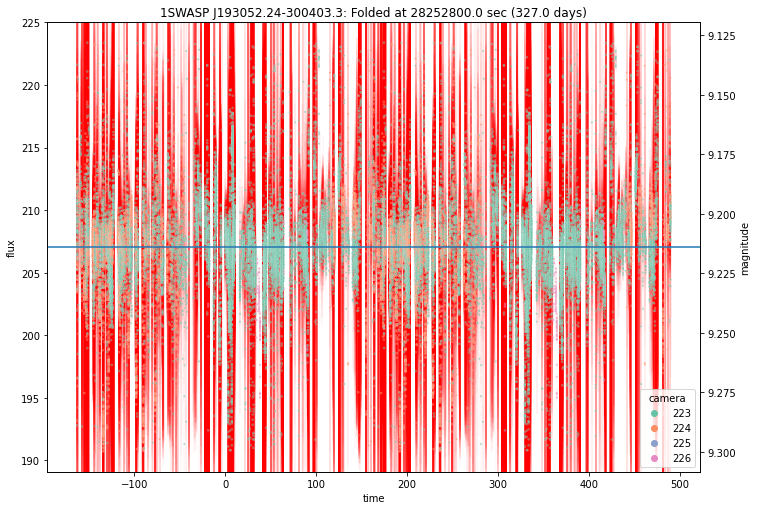

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


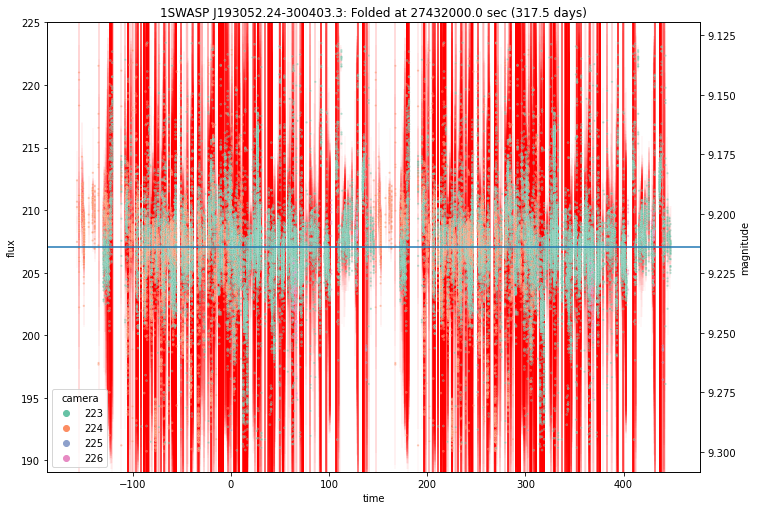

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


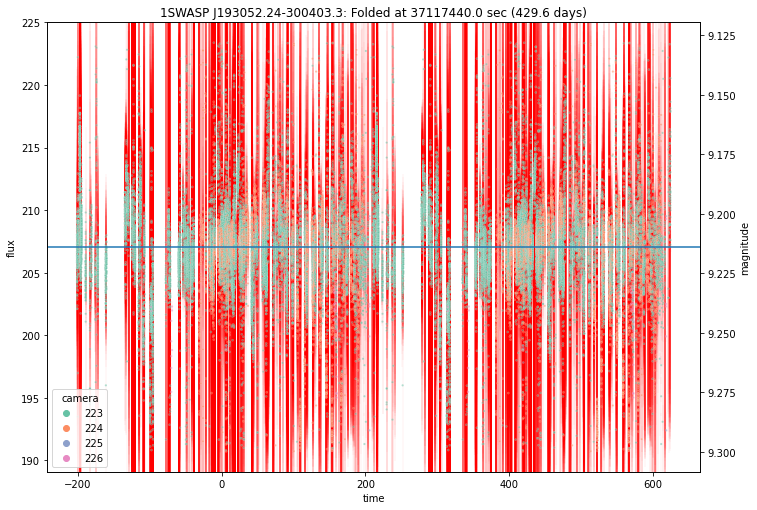

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


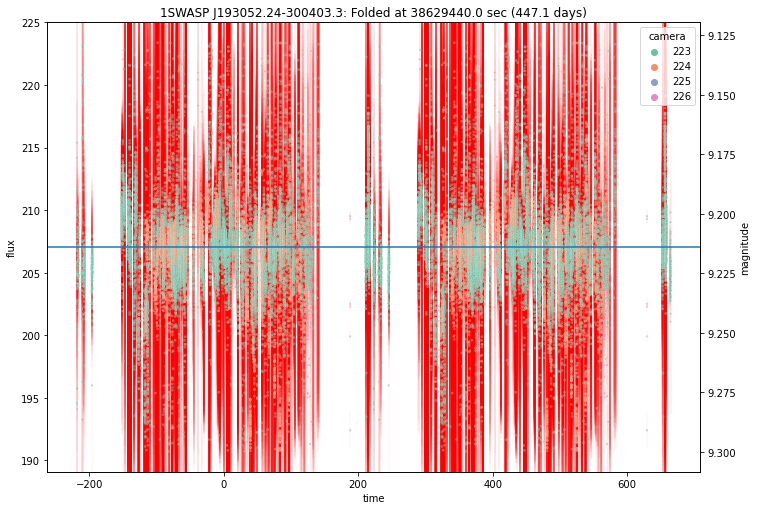

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


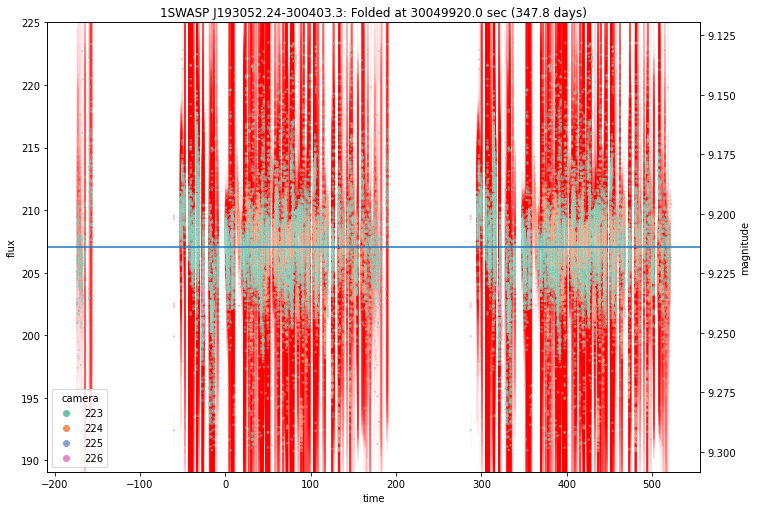

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


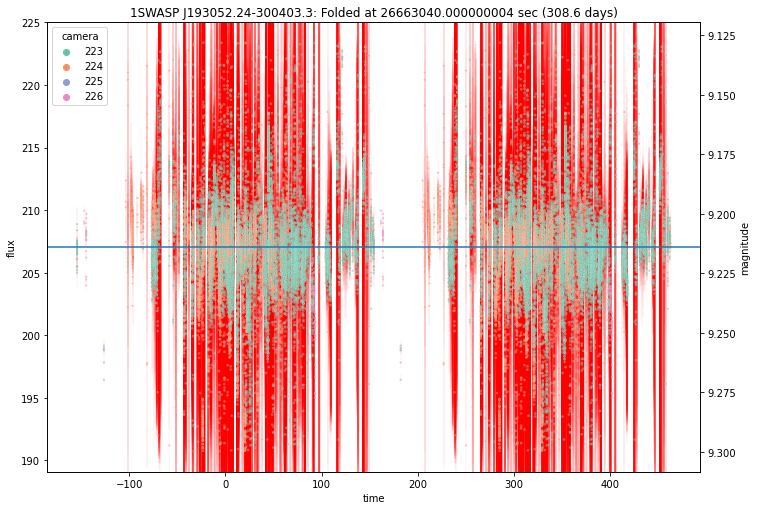

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


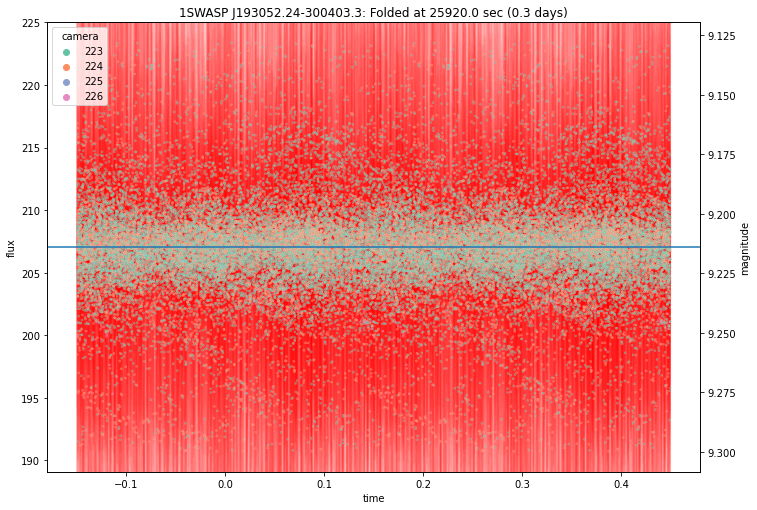

In [16]:
for i, period_row in periods.head(AUTO_FOLDED_PLOTS).iterrows():
    period = period_row['period']
    folded_ts_data = get_folded_ts(timeseries, period)
    f, ax = pyplot.subplots(figsize=(11.7,8.27))
    seaborn.scatterplot(
        data=folded_ts_data,
        x='time',
        y='flux',
        alpha=0.5,
        s=5,
        palette='Set2',
        hue='camera',
    )
    lims = pyplot.ylim()
    pyplot.axhline(numpy.median(folded_ts_data['flux']))

    pyplot.errorbar(folded_ts_data['time'], folded_ts_data['flux'], yerr=folded_ts_data['err'], ecolor='red', ls='none', zorder=-1, alpha=0.5, elinewidth=0.1)

    pyplot.ylim(lims)
    ax2 = ax.twinx()
    ax2.set_ylim(f2mag(lims[0]), f2mag(lims[1]))
    ax2.set_ylabel('magnitude')
    pyplot.title(f'{SWASP_ID}: Folded at {period * 86400} sec ({period} days)')
    pyplot.show()